# Software/Hardware co-design for a SRAM-based Spiking Neuron Network
---
<a href="https://colab.research.google.com/drive/1fEJQA3VfL_cfDpT-yM9wdNjEOtg2TcOB?authuser=2" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Copyright 2024 EDABK Laboratory
SPDX-License-Identifier: Apache-2.0
```

*This notebook best viewed on Google Colab.*

|Name|Affiliation| Email |IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|:----------:|
|Minh D. Nguyen (Lead)|Hanoi University of Science and Technology|minh.nguyenduc1@hust.edu.vn|No|No|
|Phuong Linh Nguyen|Institute Polytechnique de Paris|phuong-linh.nguyen@ip-paris.fr|No|No|


We propose a software/hardware co-design framework for developing an SRAM-based Spiking Neural Network (SNN) Accelerator. The framework begins with Python-based training of a configurable SNN and progresses to generating a hardware neuron core in GDSII format. The hardware neuron core, synthesized using OpenLane and SkyWater 130nm technology, supports 256 axons and 32 neurons, modeling 256×32 synaptic connections. Leveraging the hardware/software co-design methodology and control software, the framework enables the implementation of arbitrarily large SNNs. In this work, we demonstrate a 1,280-neuron network, arranged across 5 logical neuron cores, which achieves 94% accuracy on the MNIST dataset.

## 1. Introduction
---

### 1.1. Motivation

1. **The Energy Demand of AI Models**:
  - The advancement of artificial intelligence (AI) has led to remarkable progress, offering unprecedented performance capabilities. However, this progress has ***exponentially*** increased energy consumption and requires extensive hardware resources.

 &rarr; The need for more energy-efficient solutions, particularly those inspired by biological systems &rarr; ***Spiking Neural Networks***

2. **The Overhead of Data Movement**:
  - A significant portion of the energy consumed in modern computing systems stems from data movement rather than computation. It creates a bottleneck in system efficiency.

  &rarr; To address this challenge: in-memory computing (IMC) techniques

3. **The Lack of a Comprehensive, Flexible Framework for SNNs**:
  - When design a accelerator, if the frameworks lack of automation and flexibility, developers are required to manually reconfigure the system when modifying the network, such as changing the size of an intellectual property (IP) block.

 &rarr; Need for a comprehensive, full-flow framework with a high level of abstraction

### 1.2. Notebook Objactive

In this work:
- Basic idea of what is [SNN](https://en.wikipedia.org/wiki/Spiking_neural_network) is? The operation of one of the most popular SNN neuron model - Leaky-integrated and Fire ([LIF](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_2.html)) model.
- Full-flow configurable framework for designing, simulating and testing SNN accelerator IP:
  - How to create and training a SNN model using tensorflow for handwriting classification task?
  - How to build test routine and run RTL behavior simulation of SNN accelerator IP using [cocotb](https://github.com/cocotb/cocotb)?
  - How to implement IP through [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) RTL to GDS flow targeting the open-source [SKY130 PDK](https://github.com/google/skywater-pdk/)?
  - How to obtain the result after imnplementation and evaluate the performance?

Another main purpose of this notebook is to provide a good starting point if in the future you want to design a accelerator new model, keep the interfce of IP and just need to change the RTL source, everything should be good to go.

### 1.3. Notebook Organization

- Section 2 provides the theoretical background of the SNN model from which our framework is derived, as well as an introduction to the concept of Compute-in-Memory (CIM).

- Section 3 outlines the workflow of the framework, offering a detailed step-by-step discussion, including the code blocks used at each stage and the configurations available to users.

## 2. Background
---

### 2.1. Spiking Neural Network (SNN)

**SNN VS ANN**

SNN is a particular type of artificial neural network (ANN) that is more akin to the human brain, taking into account notions of time and being motivated by the spiking activity. Unlike traditional ANNs that use continuous values for computation, SNNs operate based on discrete and asynchronous electronic pulses, called spikes, for communication between layers.

![Description](https://drive.google.com/uc?id=10c8nKnCndPlgNoQvCbVj1mcD2UESTD6m)

**NEURON MODEL**:

Several mathematical neuron models have been proposed based on how they model the properties and closeness of biological neurons. The integrate-and-fire (IF) model is the simplest form of a spiking neuron but it sacrifices a considerable amount of accuracy for computational efficiency. With the idea of considering the leak of membrane potential over time, the Leaky Integrate-and-Fire (LIF) model is widely used in hardware accelerator implementations. It is a balanced approach, offering reasonable accuracy, computational simplicity, and biological plausibility.

The LIF neuron behavior is depicted using the following equation:

$$V_i(n+1) = V_i(n) + V_l + \sum_i W_{i,j}S_j$$
where:
- $V_i(n+1)$: the membrane potential of neuron i at time step $n+1$
- $V_l$: the leakage value of the neuron, typically non-positive value
- $W_{i,j}$: the weight of the connections between axon $j$ and neuron $i$
- $S_j$: the spike status, indicating whether there is a spike from axon j or not

**FROM BRAIN TO A CHIP**:

Human nerve cells are organized into modules. Therefore, [RANC](https://github.com/UA-RCL/RANC) team roposed a 2D mesh network consisting of multiple cores to emulate this structure. Each hardware core includes 256 neurons and 256 axons, resembling a biological neuron module, and the network of these cores is expected to have brain-like processing capabilities.

Please go to [RANC](https://github.com/UA-RCL/RANC) for more detaile aboout the mathematical basis of RANC SNN model, if you are interested. Our IP also inspired by RANC core structure. We use a ICM appraoch as well as a ent-drivent approach to save energy, sparsity utilization to implement a **256x32** IP core instead of the core instead of implement it in a sequential manner.

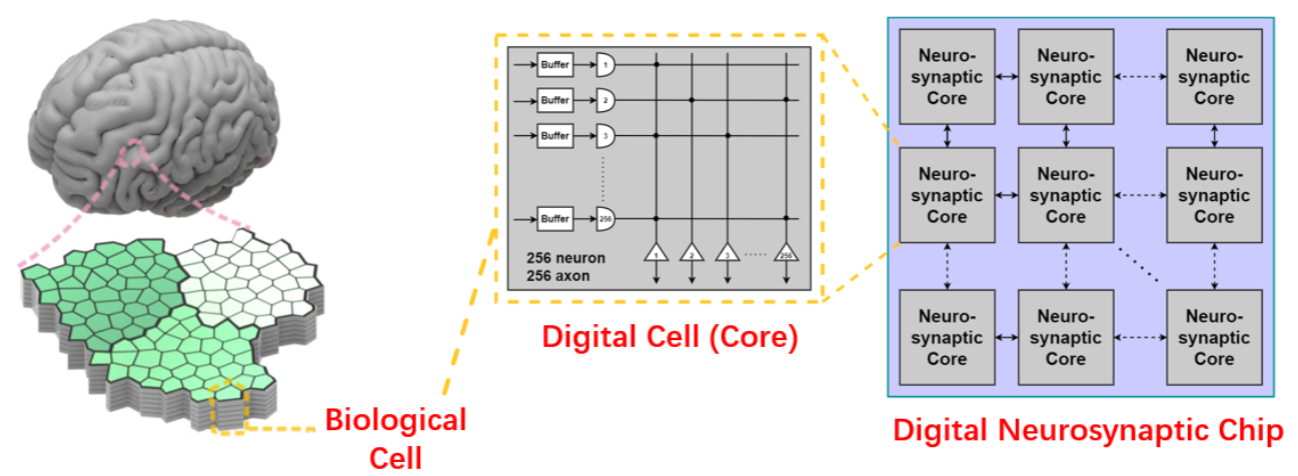

### 2.2. Compute In Memory (CIM)

The von Neumann bottleneck caused by the high data movement frequency leads to inefficiency and high power consumption. Nowadays, many efforts have been made to integrate the computation into the memory itself, aiming to reduce the high data transfer cost. These approaches are often referred to as in-memory computing (IMC), compute in memory, or processing in memory, as depicted in below image.

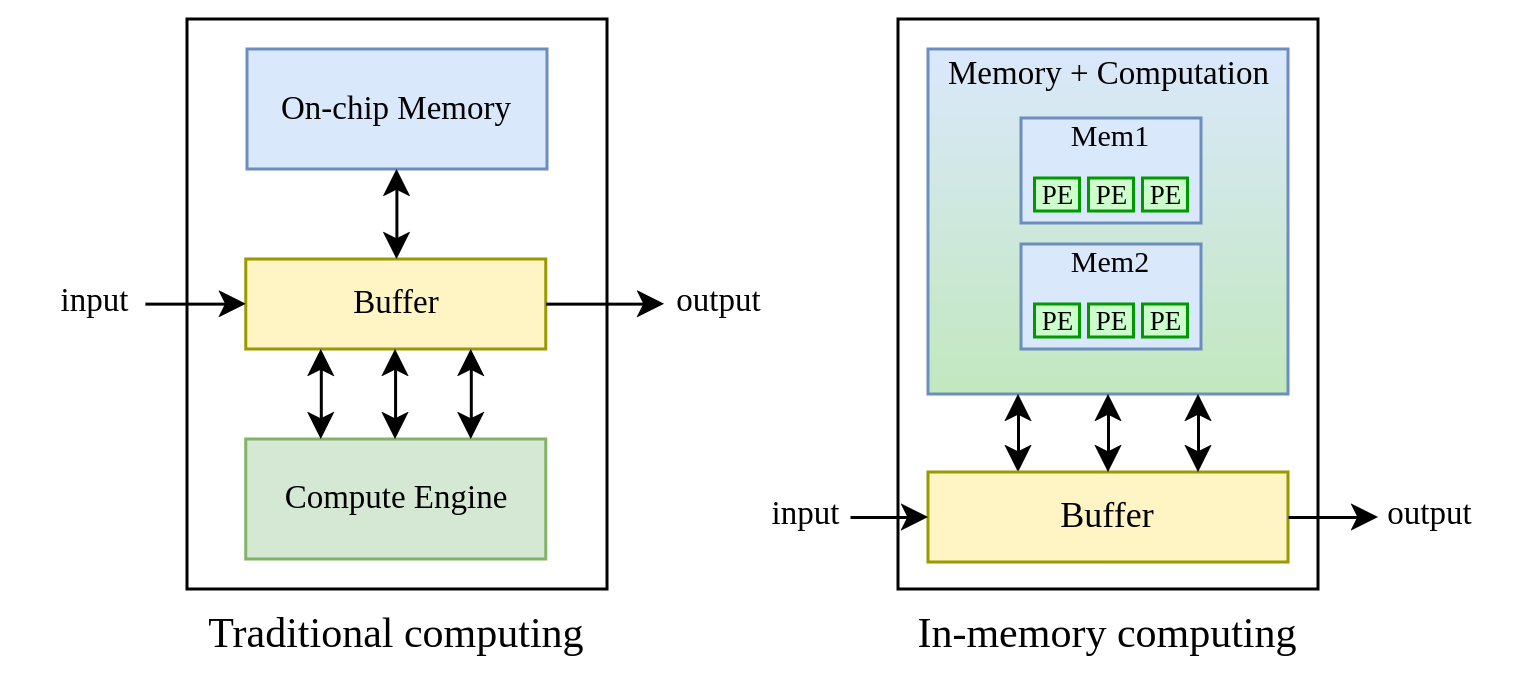

Instead of fetching data from the memory to the compute unit as in traditional computing engines, in IMC architecture, data stays in the memory while the integrated logic performs computations in place without moving outside.

Inside the memory of the IMC engine, there can be multiple memory types, each consisting of many processing elements (PEs). This architecture shifts from a compute-centric architecture to a memory-centeric or combined architecture, solving the von Neumann bottleneck, especially for data-intensive applications such as AI and ML

## 3. Proposed Framework
---

### 3.1. Workflow and IP SPEC

#### Workflow

The proposed workflow is designed to receive high-level inputs, enabling non-experts and individuals without a background in hardware design to easily understand and execute the flow.

The workflow must run seamlessly and cover all stages, from training to final implementation. It should automatically generate all necessary input and output files at each step based on the high-level inputs provided by the user. This ensures ease of use when modifying architectural sizes, IP configurations, or when used by non-specialists.

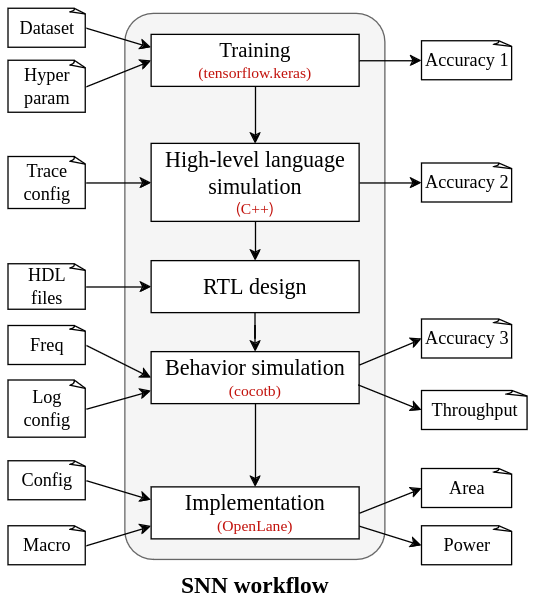

The figure above outlines the steps of the workflow, the high-level input files and the critical performance metrics obtained:

**INPUT**:

| **Input**            | **Description**                                                                 |
|----------------------|---------------------------------------------------------------------------------|
| **Dataset**          | The dataset chosen by the user. In this case, MNIST is used.                    |
| **Hyper param**  | Hyper parameters of the neural network, such as the number of layers, axons, and neurons per layer. |
| **Trace config** | Option to trace specific parameters/axons/neurons during simulation for debugging purposes.  |
| **HDL files**        | Design files for the IP core.                          |
| **Freq**        | The operating frequency of the IP.                                             |
| **Log config** | Option to save log files during simulation using cocotb for debugging purposes.       |
| **Macro**    | Results from macros used in the design, such as LEF, DEF, and netlist files. |

**STAGES**:

The workflow proceeds through five main steps:

1. Training:
    
    The SNN model is trained using tensorflow.keras. This step produces a trained model based on the input dataset and specified hyperparameters.

2. High-Level Language Simulation:
    
    This step uses a high-level language (C++) to simulate the mathematical behavior of the IP based on the trained model parameters from the previous step. The rationale for this step is detailed in Section 3.3.

3. RTL Design:
   
    Design and optimize the IP.
    
4. Behavioral Simulation:
   
    Using cocotb, an open-source Python-based framework, to run behavior simulation of the IP. In this step, inference is performed on a user-specified number of images to evaluate the design.

5. Implementation:
    The final implementation is carried out using the OpenLane flow, producing a GDSII file along with associated reports and other result files. This step completes the end-to-end flow.

#### Overall system

Figure below presents the high-level specification and modeling of the system.

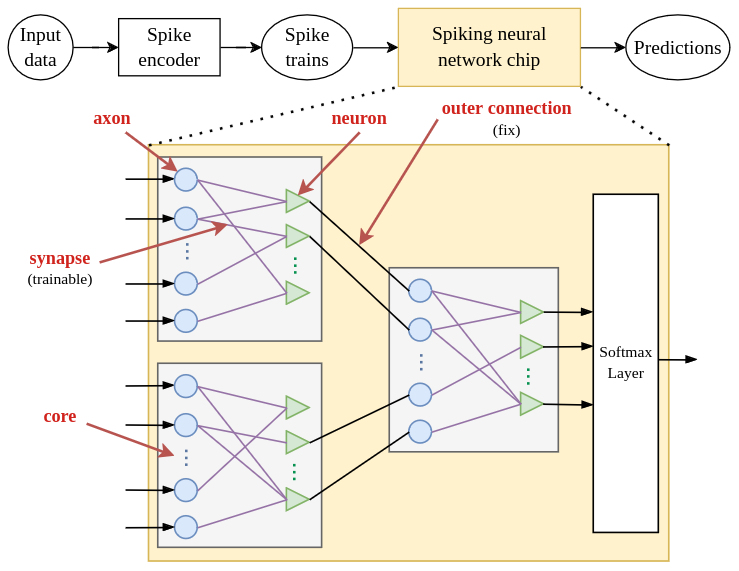

- **Inputs**: The system receives encoded spike trains as input. The input can either be loaded statically onto the system via software before compilation or fed dynamically during runtime through communication ports.

- **Outputs**: The output is the final prediction results of SNN, which can be sent to other systems for display or further processing.

- **Input-output relationship**: The system implements a SNN logic architecture with multiple layers, each of which contains cores as a basis element. Within each core, there are multiple axons that receive spikes via connections with neurons in the previous layer (referred to as outer connections) or from  the input. Then, spikes are routed  to neurons within the same core through interconnections (synapses). Neurons of the final layer feed their output spikes into a softmax layer for generating the final result. It is worth noting that the outer connections are fixed by the network topology, while the interconnections are trainable.

**HARDWARE-SOFTWARE CO-DESIGN**:

To enhance the flexibility and scalability of the system while maintaining a simple design, we use the hardware-software co-design methodology and mapping the system into software and hardware.

- Elements used in the computation phase (such as neurons, axons, and synapses) as well as the computations themselves, are implemented in hardware to leverage computational speed and energy efficiency.

- On the other hand, software is utilized for complex tasks such as routing packets between cores and performing the softmax layer. Implementing these complex tasks in software reduces the hardware complexity, thereby decreasing hardware resources and chip area.

- Furthermore, to minimize complexity and area while enhancing flexibility at the cost of moderate throughput, the system is designed with hardware comprising only a single core (with size **256x32**). Software is further used for scheduling and controlling the hardware block, facilitating the implementation of ***any network structures*** configured in firmware.

In summary:

- There is only one physical core, but it can act as multiple cores thanks to software control.

- This is feasible because the cores have identical structures, differing only in their parameter sets (such as synapse_matrix parameters, neuron parameters). Therefore, we can build just one physical core and use software to switch cores (when needed) by saving the parameters of the old core after computation and loading the parameter set of the new core.

- The software will help determine which core the outgoing packets will go to, identify which core is currently in use, and manage the scheduler for packets to the core, as well as the core switching process.

#### IP specification

This notebook only focus on designing a workflow to seveloping IP core (hardware part)

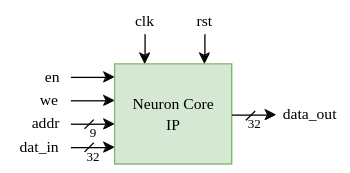

Abouve figure illustrates the top module of the Neuron Core IP module. By leveraging the in-memory computing (IMC) technique, the IP features input and output signals same as a conventional RAM block.

This design facilitates the easy integration of this module into existing SoC systems using standard memory integration methods (integrating memory is a fundamental task in SoC design, typically following established blueprints).

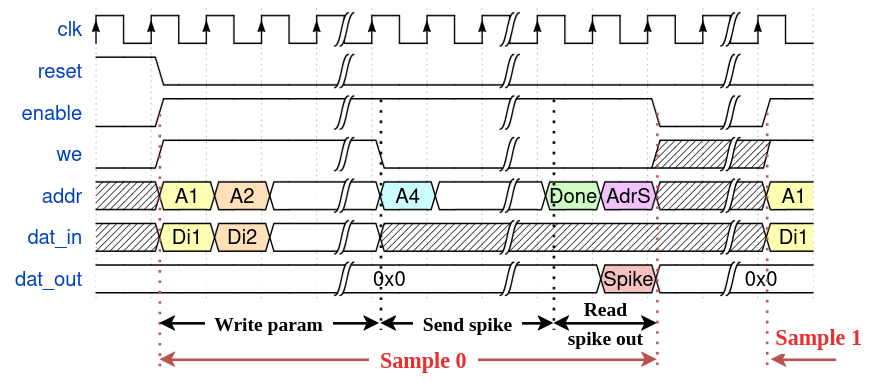

**FUNCTIONAL BEHAVIOR**:
Above figure depicts the functional behavior of the IP. There are three main phases for the IP process a sample: Write param, Send spike, and Read spike out

1. ***Write param***: In this phase, the CPU requires to write to the memory of the IP in order to load the necessary parameters of SNN. During this phase, this IP behaves like a traditional RAM.

2. ***Send spike***: Once all parameters have been loaded into the hardware IP, encoded spikes are sent to the IP utilizing read operations. It is noteworthy that during this phase, although the IP receives read instructions, it does not act like a normal RAM. Instead, it performs computational tasks concurrently while extracting information from the read instructions. All neurons within the IP compute in parallel in the same cycle as the spike input cycle.

3. Read Spike Out: This phase consists of two steps: sending a done signal and reading output spikes. At first, the CPU sends a special signal to the ip by performing a read operation at a specific address, which is the `dONE` address, to indicate that all the spikes are sent. In this cycle, the IP is in computing mode, comparing the current voltages of each neuron to the threshold to generate spikes. Next, in the reading spike output step, the software requests a read operation from the IP. It operates as regular a RAM and sends the output spikes stored at the `AdrS` address (as in picture) to the data out pin.


#### Set up working dir

Set up working directory as in below picture

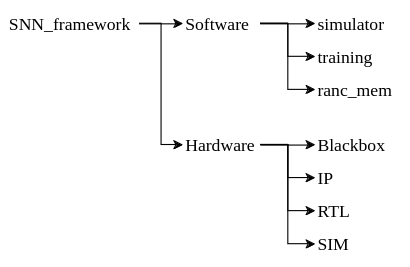

In [ ]:
# Mount GGDrive
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/deLini1612/SNN_framework.git

/content/drive/MyDrive
Cloning into 'SNN_framework'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91 (from 1)
Receiving objects: 100% (91/91), 52.98 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (49/49), done.


In [ ]:
# Set up base dirs
ROOT_DIR="/content/drive/MyDrive/SNN_framework"

SOFT_DIR=ROOT_DIR+"/Software"
HARD_DIR=ROOT_DIR+"/Hardware"

TRAIN_DIR=SOFT_DIR+"/training"
C_SIM_DIR=SOFT_DIR+"/simulator"
RANC_MEM_DIR=SOFT_DIR+"/ranc_mem"

RTL_SOURCE_DIR=HARD_DIR+"/RTL"
SIM_DIR=HARD_DIR+"/SIM"
HW_MEM_DIR = SIM_DIR+"/mem"

BLACKBOX_DIR=HARD_DIR+"/Blackbox"
IP_DIR = HARD_DIR+"/IP"

DFFRAM_MACRO= BLACKBOX_DIR+"/DFFRAM"
NEURON_INSTANCE_MACRO=BLACKBOX_DIR+"/neuron_instance"

### 3.2. Training SNN model

In this stage, based on the dataset and hyperparameter that user provides, we train a SNN network by using tensorflow.keras

Picture below depicts the training process as well as the output files (generated in `Save reseult` part in section ***3.2. Training***), which will be used to feed to simulators.

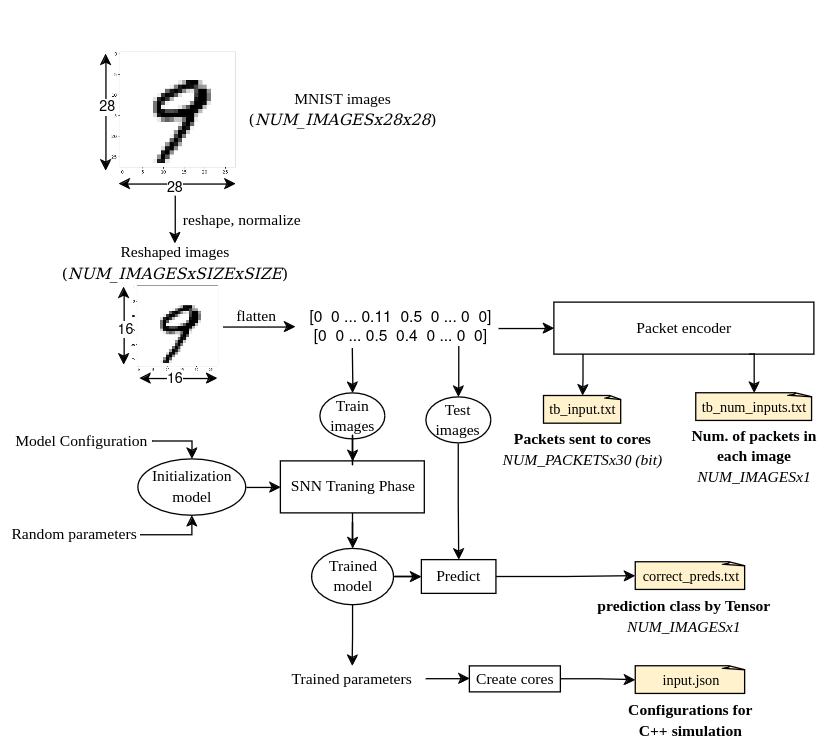

#### Prepare and import package

In [ ]:
# Set up training output file path
MODEL_CONFIG_FILE=SOFT_DIR+"/model_config.json"
TF_PREDS_FILE = TRAIN_DIR+"/mnist_tf_preds.txt"
CORRECT_PREDS_FILE = TRAIN_DIR+"/mnist_correct_preds.txt"
SIM_INPUT_FILE = SOFT_DIR+"/sim_network_config.json"

In [ ]:
!pip uninstall tensorflow -y
!pip uninstall keras -y
!pip install tensorflow==2.15.0
!pip install keras==2.15.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled m

In [ ]:
# Move to working directory
%cd {SOFT_DIR}

# Clean old version (if needed)
!rm -f {MODEL_CONFIG_FILE}
!rm -rf {TRAIN_DIR}
!rm -rf {RANC_MEM_DIR}
!rm -rf {C_SIM_DIR}
!unzip -o "training.zip"

/content/drive/MyDrive/SNN_framework/Software
Archive:  training.zip
   creating: training/
   creating: training/rancutils/
  inflating: training/rancutils/setup.py  
  inflating: training/rancutils/README.md  
   creating: training/rancutils/rancutils.egg-info/
  inflating: training/rancutils/rancutils.egg-info/dependency_links.txt  
  inflating: training/rancutils/rancutils.egg-info/not-zip-safe  
  inflating: training/rancutils/rancutils.egg-info/SOURCES.txt  
  inflating: training/rancutils/rancutils.egg-info/requires.txt  
  inflating: training/rancutils/rancutils.egg-info/PKG-INFO  
  inflating: training/rancutils/rancutils.egg-info/top_level.txt  
   creating: training/rancutils/build/
   creating: training/rancutils/build/bdist.linux-x86_64/
   creating: training/rancutils/build/lib/
   creating: training/rancutils/build/lib/rancutils/
  inflating: training/rancutils/build/lib/rancutils/packet.py  
  inflating: training/rancutils/build/lib/rancutils/serialization.py  
  inflat

In [ ]:
%cd {TRAIN_DIR}
!pip install "./tealayers/tealayer2.0"
!pip install "./rancutils"
!pip install "./edabkutils"

/content/drive/MyDrive/SNN_framework/Software/training
Processing ./tealayers/tealayer2.0
  Preparing metadata (setup.py) ... done
  Created wheel for tealayer2: filename=tealayer2-2.0-py3-none-any.whl size=8376 sha256=c595f5aef12d4237decfd160202142a7ddc6b0470d4887bee5c0c75df4b0f1b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-9md3286d/wheels/4c/47/83/0f99289a1394745d2d914978afed0757c091420c1ee04ad658
Successfully built tealayer2
Processing ./rancutils
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 11.5 MB/s eta 0:00:00
  Created wheel for rancutils: filename=rancutils-0.1-py3-none-any.whl size=9143 sha256=20acdccf838fec9873286f0d1167281a5f86d8deb3e0c62b33852caa3f8b4f5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-whc55hnj/wheels/af/5a/16/2e043f63bd78b3ad147ff9e354c925c4a2f27b4a28c62bf0c5
Successfully built rancutils
Processing ./edabkutils
  Prep

In [ ]:
from tealayer2 import Tea, AdditivePooling, tea_weight_initializer
from tensorflow.keras.layers import Flatten, Activation, Input, Lambda, concatenate
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import math
import cv2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.optimizers.legacy import Adam
from edabkutils.modelize import auto_train_config, save_configure_json, get_configs, get_core_arrange, write_config_sim

Instructions for updating:
non-resource variables are not supported in the long term


#### Configure model hyperparameter

In [ ]:
# @markdown Fill the number of layers, click the ▷ button then fill the configuration for each layer.
# @markdown
# @markdown > **Note**: In our architecture, there are some constrains:
# @markdown - Total number of neurons in layer i = total number of axons in layer i+1.
# @markdown - Number of cores in layer i must be divisible by the number of core in layer i+1.
# @markdown - Number of cores in last layer is 1 -> If there is just 1 layer, there is 1 core and number of axons is a square.
# @markdown - Number of neurons in last layer must be divisible by the number of classes needed for classification.
# @markdown - Number of axons is power of two.
# @markdown - Number of axons, number of neurons is less than 257.


import ipywidgets as widgets
from IPython.display import display

mode = "Default"  #@param ["Default", "User defined configurations"]
number_of_layers = 2 #@param {type:"integer"}

if (mode == "User defined configurations"):
  layer_inputs = []

  # Each layer configuration
  for i in range(number_of_layers):
      num_cores = widgets.IntText(value = 1, description=f'Number of Cores:', style={'description_width': 'initial'})
      num_axons = widgets.IntText(value = 32, description=f'Number of Axons (Max = 256):', style={'description_width': 'initial'})
      num_neurons = widgets.IntText(value = 32, description=f'Number of Neurons (Max = 256):', style={'description_width': 'initial'})

      layer_header = widgets.HTML(value=f"<br><b>=============== Layer {i+1} ===============</b>")

      layer_inputs.append((layer_header, num_cores, num_axons, num_neurons))

  # Display for user input
  display(*[item for sublist in layer_inputs for item in sublist])  # Flatten the list for display

In [ ]:
if (mode == "User defined configurations"):
      model_configs = get_configs(layer_inputs)
else:
  model_configs = [[4, 256, 64], [1, 256, 250]]
  number_of_layers = 2

[x_range, y_range, core_arrange] = get_core_arrange(model_configs)

print("Model configurations:", model_configs)
print("Core arrangement:", core_arrange)
save_configure_json(MODEL_CONFIG_FILE,model_configs)

Model configurations: [[4, 256, 64], [1, 256, 250]]
Core arrangement: [[[0, 0], [1, 0], [2, 0], [3, 0]], [[0, 1]]]
Model configuration is saved into /content/drive/MyDrive/SNN_framework/Software/model_config.json.


#### Train model

In [ ]:
[pic_size, slice_ind] = auto_train_config(model_configs[0][0], model_configs[0][1])
print(f"Choosen picture size: {pic_size}")

Choosen picture size: 28


In [ ]:
# Prepare dataset for training

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
num_label = 10

# resize the input shape
X_train = np.array([cv2.resize(img, (pic_size, pic_size)) for img in X_train])
X_test = np.array([cv2.resize(img, (pic_size, pic_size)) for img in X_test])
X_train = X_train.reshape(-1, pic_size, pic_size, 1)
X_test = X_test.reshape(-1, pic_size, pic_size, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Initial the SNN network

# Shape the input to right size
inputs = Input(shape=(pic_size, pic_size, 1))

# Flatten the inputs
flattened_inputs = Flatten()(inputs)
layer = [] # List of cores in layers

number_of_cores = 0

# For loop for each layer
for layer_ind in range(number_of_layers):
    number_of_cores = number_of_cores + model_configs[layer_ind][0]
    for core_ind in range(model_configs[layer_ind][0]):
      if (layer_ind==0): # If it's the first layer -> feed input
        core = Lambda(lambda x : x[:,slice_ind[core_ind][0]:slice_ind[core_ind][1]])(flattened_inputs)
        core = Tea(units=model_configs[layer_ind][2], name=f'tea_{layer_ind+1}_{core_ind+1}')(core)
        layer.append(core)
      else:
        core_num_concate = model_configs[layer_ind-1][0]//model_configs[layer_ind][0]
        core = concatenate(layer[0:core_num_concate])
        core = Tea(units=model_configs[layer_ind][2], name=f'tea_{layer_ind+1}_{core_ind+1}')(core)
        layer.append(core)
        layer = layer[core_num_concate:]

network = AdditivePooling(num_label)(layer[0])

In [ ]:
# Train
predictions = Activation('softmax')(network)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Using callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_acc',  # monitor the accuracy of validation set
    patience=5,  # Allow max 5 epoch without improvement
    min_delta=0.001,
    mode='max',
    verbose=1
)

model.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=100,  # Max number of epoch
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]  # callback for early stopping
)

score = model.evaluate(X_test, Y_test, verbose=0)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 7s 153us/sample - loss: 0.5771 - acc: 0.8192 - val_loss: 0.4268 - val_acc: 0.8615
Epoch 2/100
48000/48000 [==============================] - 8s 170us/sample - loss: 0.2888 - acc: 0.9118 - val_loss: 0.3485 - val_acc: 0.8830
Epoch 3/100
48000/48000 [==============================] - 3s 65us/sample - loss: 0.2287 - acc: 0.9309 - val_loss: 0.2910 - val_acc: 0.9082
Epoch 4/100
48000/48000 [==============================] - 3s 62us/sample - loss: 0.2020 - acc: 0.9381 - val_loss: 0.2582 - val_acc: 0.9206
Epoch 5/100
48000/48000 [==============================] - 4s 84us/sample - loss: 0.1767 - acc: 0.9452 - val_loss: 0.2720 - val_acc: 0.9142
Epoch 6/100
48000/48000 [==============================] - 5s 100us/sample - loss: 0.1668 - acc: 0.9489 - val_loss: 0.2681 - val_acc: 0.9123
Epoch 7/100
48000/48000 [==============================] - 3s 62us/sample - loss: 0.1513 - acc: 0.9526 - va

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 256)                  0         ['flatten[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 256)                  0         ['flatten[0][0]']             
                                                                                              

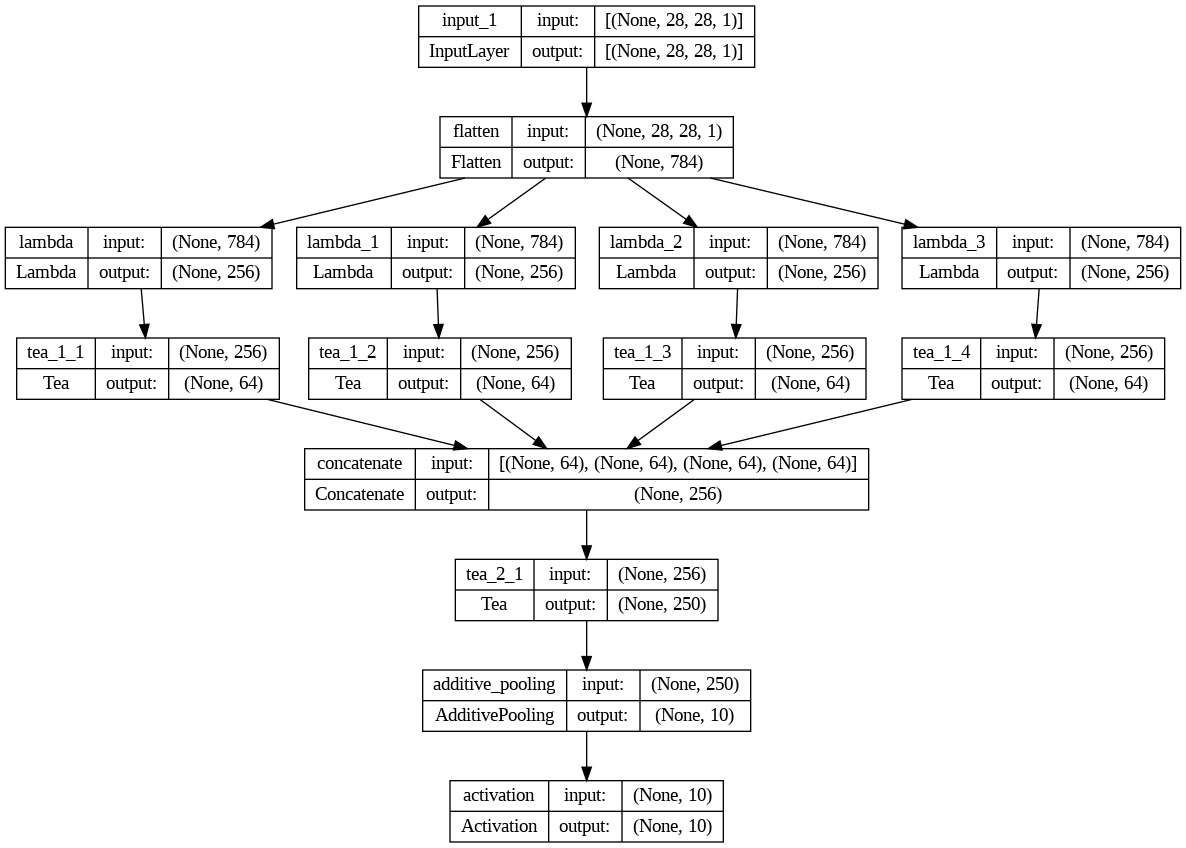

In [ ]:
plot_model(model, to_file=TRAIN_DIR+'/model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# @title Model prediction
# @markdown Fill the number of test sample, click the ▷ button to predict, save prediction and the real label

import ipywidgets as widgets
from IPython.display import display

num_test_samples = 100 #@param {type:"integer"}
predict = model.predict(X_test[:num_test_samples,:])

predict_labels = []
for i in predict:
  predict_labels.append(np.argmax(i)) # xác suất rơi vào label nào lớn nhất
test_predictions = to_categorical(y=predict_labels, num_classes=num_label) # lưu dưới dạng one-hot
np.save(TF_PREDS_FILE, test_predictions)
print(f"Saved prediction result by tf in {TF_PREDS_FILE}.npy")
np.save(CORRECT_PREDS_FILE, Y_test[:num_test_samples,:])
print(f"Saved correct result by tf in {CORRECT_PREDS_FILE}.npy")

correct_bit = np.sum(test_predictions == Y_test[:num_test_samples,:])
correct_sample = num_test_samples - (num_test_samples*10 - correct_bit)//2
print(f"Accuracy: {correct_sample}/{num_test_samples} ({100*correct_sample/num_test_samples}%)")

Saved prediction result by tf in /content/drive/MyDrive/SNN_framework/Software/training/mnist_tf_preds.txt.npy
Saved correct result by tf in /content/drive/MyDrive/SNN_framework/Software/training/mnist_correct_preds.txt.npy
Accuracy: 98/100 (98.0%)


#### Save result

In [ ]:
from rancutils.teaconversion import create_cores, create_packets, Packet
from rancutils.output_bus import OutputBus
from rancutils.serialization import save as sim_save
from rancutils.emulation import output_for_testbench, output_for_streaming

In [ ]:
# Convertion to ranc format

# Flaten the test dataset and separated it into different parts corresponding to each input core
x_test_flat = X_test.reshape((10000, pic_size*pic_size))
partitioned_packets = []
for i in range (len(slice_ind)):
  partitioned_packets.append(x_test_flat[:num_test_samples, slice_ind[i][0]:slice_ind[i][1]])

# Create core and package using function in rancutils package
cores_sim = create_cores(model, number_of_layers, neuron_reset_type=0)
packets_sim = create_packets(partitioned_packets)

# Create output_bus using function OutputBus(coordinate, num_outputs)
output_bus_sim = OutputBus((0, number_of_layers), num_outputs=model_configs[number_of_layers - 1][2])

In [ ]:
# Generate structural input and configure file for C++ RANC architecture simulator
sim_save(SIM_INPUT_FILE, cores_sim, packets_sim, output_bus_sim, indent=2)


In [ ]:
# Generate mem file for network trained parameter (matrix connection + neuron params)
output_for_streaming(cores_sim,output_path=RANC_MEM_DIR)
output_for_testbench(packets_sim,
                         Y_test[:num_test_samples,:],
                         output_path=SOFT_DIR,
                         input_filename=RANC_MEM_DIR+'/tb_input.txt',
                         correct_filename=RANC_MEM_DIR+'/tb_correct.txt',
                         num_inputs_filename=RANC_MEM_DIR+'/tb_num_inputs.txt',
                         num_outputs_filename=RANC_MEM_DIR+'/tb_num_outputs.txt',
                         max_packet_xy=(512, 512),
                         num_axons=model_configs[0][1],
                         num_ticks=16,
                         num_outputs=model_configs[number_of_layers - 1][2])

### 3.3. C++ Simulation

The reason for performing simulation using a high-level language is that the model relies on approximations derived from the network obtained after training, converting them into binary values to represent neuron connections.

This can cause inaccuracies in the network and lead to suboptimal performance. Before proceeding with the design and implementation of the network, we will use C++ code to replicate the hardware execution process (using rounding instead of floating-point numbers as in the AI model inference during training). This ensures that the model is sufficiently accurate for implementation.

#### Configure the simulation

In [ ]:
SIM_OUT_FILE=C_SIM_DIR+"/simulator_output.txt"
SIM_TRACE_FILE=C_SIM_DIR+"/sim_trace.txt"
SIM_CONFIG_FILE=SOFT_DIR+"/sim_config.json"

TF_OUT_FILE=TRAIN_DIR + "/tf_output.txt"
CORRECT_OUT_FILE=TRAIN_DIR + "/correct_output.txt"

num_ticks = num_test_samples + 2

In [ ]:
%cd {SOFT_DIR}
!rm -rf simulator
!unzip "simulator.zip"
%cd {C_SIM_DIR}
!mkdir build
%cd build

# Create an executable simulator
!cmake ".."
!make

/content/drive/MyDrive/SNN_framework/Software
Archive:  simulator.zip
   creating: simulator/
  inflating: simulator/.gitignore    
  inflating: simulator/CMakeLists.txt  
   creating: simulator/data/
   creating: simulator/data/example/
  inflating: simulator/data/example/input.json  
   creating: simulator/data/mceliece/
  inflating: simulator/data/mceliece/mceliece-1.json  
  inflating: simulator/data/test.json  
   creating: simulator/data/vmm/
  inflating: simulator/data/vmm/josh-input.json  
   creating: simulator/extern/
  inflating: simulator/extern/cxxopts.hpp  
   creating: simulator/extern/plog/
   creating: simulator/extern/plog/Appenders/
  inflating: simulator/extern/plog/Appenders/AndroidAppender.h  
  inflating: simulator/extern/plog/Appenders/ColorConsoleAppender.h  
  inflating: simulator/extern/plog/Appenders/ConsoleAppender.h  
  inflating: simulator/extern/plog/Appenders/DebugOutputAppender.h  
  inflating: simulator/extern/plog/Appenders/EventLogAppender.h  
  inf

In [ ]:
# @markdown Choose the trace option when run the simulation then click the ▷ button.

use_sim_trace = True  #@param {type:"boolean"}
neuron_block_trace = "Logs the axons receiving spike"  #@param ["No", "Logs the LIF operation for each neuron at each tick", "Logs the axons receiving spike"]
core_trace = "Logs the received spikes of each core"  #@param ["No", "Logs the received spikes of each core"]

# Mapping string to int
trace_neuron_block_map = {
    "No": 0,
    "Logs the LIF operation for each neuron at each tick": 1,
    "Logs the axons receiving spike": 2
}
trace_core_map = {
    "No": 0,
    "Logs the received spikes of each core": 1,
}

neuron_block_trace = trace_neuron_block_map[neuron_block_trace]
core_trace = trace_core_map[core_trace]

if (use_sim_trace):
  if (core_trace == 0) and (neuron_block_trace == 0):
    raise ValueError(f"Trace sim but none trace option is picked")
else:
    neuron_block_trace = core_trace = 0

max_neuron = 2 ** math.ceil(math.log2(max(layer[2] for layer in model_configs)))
max_axon = 2 ** math.ceil(math.log2(max(layer[1] for layer in model_configs)))

write_config_sim(SIM_CONFIG_FILE, max_neuron, max_axon, x_range+1, y_range+1, neuron_block_trace, core_trace)

Write C++ simulation config file to /content/drive/MyDrive/SNN_framework/Software/sim_config.json


#### Start the simulation

In [ ]:
if (use_sim_trace):
  !{C_SIM_DIR}/build/ranc_sim -i {SIM_INPUT_FILE} -o {SIM_OUT_FILE} -c {SIM_CONFIG_FILE} {num_ticks} -t {SIM_TRACE_FILE}
  print(f"Saved trace file to {SIM_TRACE_FILE}")
else:
  !{C_SIM_DIR}/build/ranc_sim -i {SIM_INPUT_FILE} -o {SIM_OUT_FILE} -c {SIM_CONFIG_FILE} {num_ticks}

Starting simulation with 102 ticks.
Tick 1 started
Tick 2 started
Tick 3 started
Tick 4 started
Tick 5 started
Tick 6 started
Tick 7 started
Tick 8 started
Tick 9 started
Tick 10 started
Tick 11 started
Tick 12 started
Tick 13 started
Tick 14 started
Tick 15 started
Tick 16 started
Tick 17 started
Tick 18 started
Tick 19 started
Tick 20 started
Tick 21 started
Tick 22 started
Tick 23 started
Tick 24 started
Tick 25 started
Tick 26 started
Tick 27 started
Tick 28 started
Tick 29 started
Tick 30 started
Tick 31 started
Tick 32 started
Tick 33 started
Tick 34 started
Tick 35 started
Tick 36 started
Tick 37 started
Tick 38 started
Tick 39 started
Tick 40 started
Tick 41 started
Tick 42 started
Tick 43 started
Tick 44 started
Tick 45 started
Tick 46 started
Tick 47 started
Tick 48 started
Tick 49 started
Tick 50 started
Tick 51 started
Tick 52 started
Tick 53 started
Tick 54 started
Tick 55 started
Tick 56 started
Tick 57 started
Tick 58 started
Tick 59 started
Tick 60 started
Tick 61 start

#### Compare: C++ sim output vs Python TF output

In [ ]:
# Process the output to collect final classificaiton results and compare against Tensorflow predictions
import numpy as np
from rancutils.simulator import collect_classifications_from_simulator
tf_output = np.load(TF_PREDS_FILE+".npy")
correct_output = np.load(CORRECT_PREDS_FILE+".npy")
simulator_output = collect_classifications_from_simulator(SIM_OUT_FILE, num_classes=num_label)
simulator_output = simulator_output[2:]

tf_output_flat = np.array([0] * tf_output.shape[0])
for i in range(tf_output.shape[0]):
    output_i = tf_output[i, :]
    decision = np.where(output_i == max(output_i))[0]
    if len(decision) > 1:
        decision = decision[0]
    tf_output_flat[i] = decision
tf_output = tf_output_flat

correct_output_flat = np.array([0] * correct_output.shape[0])
for i in range(correct_output.shape[0]):
    output_i = correct_output[i, :]
    decision = np.where(output_i == max(output_i))[0]
    if len(decision) > 1:
        decision = decision[0]
    correct_output_flat[i] = decision
correct_output = correct_output_flat

np.savetxt(TF_OUT_FILE, tf_output, fmt='%d')
print(f"Saved the tf predicted output to {TF_OUT_FILE}\n")
np.savetxt(CORRECT_OUT_FILE, correct_output, fmt='%d')
print(f"Saved the correct output to {CORRECT_OUT_FILE}\n")

if all(tf_output == simulator_output):
    print("Tensorflow output matches simulator output exactly!")
    print(f"Testing accuracy against correct class labels is {(len(np.where(tf_output == correct_output[:len(tf_output)])[0]) / len(tf_output)) * 100}%")
else:
    print("There are differences between Tensorflow and the simulator...")
    print(f"Differences are in indices {np.where(tf_output != simulator_output)}")
    print(f"Tensorflow thought the classes were {tf_output[np.where(tf_output != simulator_output)]}")
    print(f"The simulator thought the classes were {simulator_output[np.where(tf_output != simulator_output)]}")
    print(f"The correct classes were {correct_output[np.where(tf_output != simulator_output)]}")

Saved the tf predicted output to /content/drive/MyDrive/SNN_framework/Software/training/tf_output.txt

Saved the correct output to /content/drive/MyDrive/SNN_framework/Software/training/correct_output.txt

Tensorflow output matches simulator output exactly!
Testing accuracy against correct class labels is 98.0%


In [ ]:
CORRECT_OUT_FILE=TRAIN_DIR + "/correct_output.txt"
np.savetxt(CORRECT_OUT_FILE, correct_output, fmt='%d')
print(f"Saved the correct output to {CORRECT_OUT_FILE}\n")

Saved the correct output to /content/drive/MyDrive/SNN_framework/Software/training/correct_output.txt



### 3.4. RTL Design

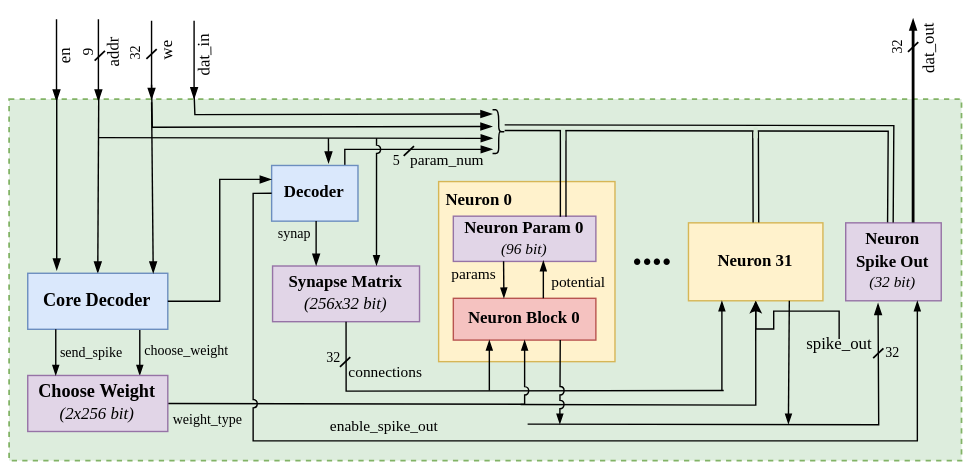

**COMPONENTS**

- **`Choose Weight`**: Based on the architecture of [`RANC`](https://arxiv.org/abs/2011.00624), each neuron has 4 weight values and which weight is used in the calculation depends on which axon fires the spike. The task of the `Choose Weight` block is to save the decision and transmit the selection to the neuron. Input spikes are encoded into the address of the axon and then analyzed into the corresponding weight.

- **`Core Decoder`**: The `Core Decoder` block is responsible for decoding from address_in to determine whether the data to be read belongs to the memory of `Choose Weight` block or other mem block (others purple blocks).

- **`Decoder`**: The `Decoder` module is responsible for decoding the incoming address to determine which part of the neuron core should be accessed. It outputs signals that indicate whether the access is for the synapse matrix, neuron parameters, or neuron spike output.

- **`Synapse Matrix`**: It's a mem based block containing the connections of the IP. This module outputs the connections of incoming axon with 32 neurons as `connections` signal, which are fed into each `Neuron Block` and act as a enable for the computing of `Neuron Block`.

- **`Neuron Spike Out`**: It captures the spikes generated by all the `Neuron Block`, indicating if any neuron has spiked.

- **`Neuron Param`**: It holds the parameters like voltage potential, thresholds, leak values, and reset values for each neuron (which will be used in `Neuron Block` to calculate new potential).

- **`Neuron Block`**: It calculates the new potential for a neuron based on the current potential, inputs, and parameters provided by `Neuron Param`. It also determines if a neuron spikes and sends this to `Neuron Spike Out`.

**MEMORY MAP**

Because we used many memory based block, as well as decoder, we need to find optimal memory map for the IP when they integrated into system in order to reduce the complexity of the decoder.

The figure below shows the memory map that we optimize, so that the number of element required for decode is minimum and we can decode each mem part just by slicing a few bits.

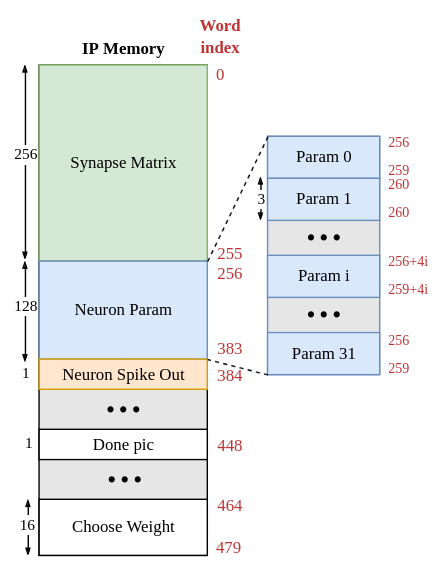

### 3.5. Cocotb Behavior Simulation

#### Setup and install dependencies

In [ ]:
COCO_DIR=SIM_DIR+"/cocotb/ip_256x32"

In [ ]:
!rm -rf {SIM_DIR}
!mkdir {SIM_DIR}
!mkdir {HW_MEM_DIR}

In [ ]:
%cd {SIM_DIR}
!apt-get install -y iverilog
!git clone https://github.com/cocotb/cocotb.git
!pip install -e ./cocotb
!rm -rf ./cocotb/docs
!rm -rf ./cocotb/tests
!rm -rf ./cocotb/examples
!rm -rf {COCO_DIR}

/content/drive/MyDrive/SNN_framework/Hardware/SIM
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  gtkwave
The following NEW packages will be installed:
  iverilog
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,130 kB of archives.
After this operation, 6,749 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 iverilog amd64 11.0-1.1 [2,130 kB]
Fetched 2,130 kB in 2s (1,391 kB/s)
Selecting previously unselected package iverilog.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../iverilog_11.0-1.1_amd64.deb ...
Unpacking iverilog (11.0-1.1) ...
Setting up iverilog (11.0-1.1) ...
Processing triggers for man-db (2.10.2-1) ...
Cloning into 'cocotb'...
remote: Enumerating objects: 32792, done.
remote: Counting objects: 100% (1448/1448), done.
remote: Compressing objects: 100% (832/832), done.
remot

In [ ]:
%cd ./cocotb/
!./setup.py build
!./setup.py install

/content/drive/MyDrive/SNN_framework/Hardware/SIM/cocotb
/bin/bash: ./setup.py: /usr/bin/env: bad interpreter: Permission denied
/bin/bash: ./setup.py: /usr/bin/env: bad interpreter: Permission denied


In [ ]:
!mkdir {COCO_DIR}
%cd {COCO_DIR}

mkdir: cannot create directory ‘/content/drive/MyDrive/SNN_framework/Hardware/SIM/cocotb/ip_256x32’: File exists
/content/drive/MyDrive/SNN_framework/Hardware/SIM/cocotb/ip_256x32


#### Generate input and output files for testbench

In [ ]:
from edabkutils.mem_converter import csram_convert, packet_convert, tc_convert

In [ ]:
path_to_outmem = HW_MEM_DIR

in_packet = RANC_MEM_DIR+"/tb_input.txt"
encode_packet = path_to_outmem + "/tb_axon_addr.txt"
file_synapse = []
file_param = []
file_tc = []

for i in range (number_of_cores):
    input_file_name = RANC_MEM_DIR + "/csram_" + f"{i:03}" + ".mem"
    tc_ranc_file_name = RANC_MEM_DIR + "/tc_" + f"{i:03}" + ".mem"
    synapse_matrix_file_name = path_to_outmem + "/synapse_matrix_"  + str(i) + ".txt"
    neuron_param_file_name = path_to_outmem + "/neuron_param_" + str(i) + ".txt"
    tc_file_name = path_to_outmem + "/tc_" + str(i) + ".txt"
    csram_convert(input_file_name, synapse_matrix_file_name, neuron_param_file_name)
    tc_convert(tc_ranc_file_name, tc_file_name)

    file_synapse.append(synapse_matrix_file_name)
    file_param.append(neuron_param_file_name)
    file_tc.append(tc_file_name)

packet_convert(in_packet, encode_packet)

CSRAM conversion complete. Results saved in /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/synapse_matrix_0.txt and /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/neuron_param_0.txt
TC conversion complete, result is saved in /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/tc_0.txt
CSRAM conversion complete. Results saved in /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/synapse_matrix_1.txt and /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/neuron_param_1.txt
TC conversion complete, result is saved in /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/tc_1.txt
CSRAM conversion complete. Results saved in /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/synapse_matrix_2.txt and /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/neuron_param_2.txt
TC conversion complete, result is saved in /content/drive/MyDrive/SNN_framework/Hardware/SIM/mem/tc_2.txt
CSRAM conversion complete. Results saved in /content/drive/MyDrive/SNN_framework/Hardware/SIM/

#### Configure the simulation, write scripts and run IP behavior simulation

In [ ]:
import glob

top_sim = "neuron_core_256x32"
module = "test_neuron_core_256x32"

source_files = glob.glob(RTL_SOURCE_DIR + "/*.v")
source_files = [file for file in source_files if 'synapse_matrix_macro.v' not in file]
source_file_verilog = ' '.join(source_files)

In [ ]:
# @markdown Choose the simulation configuration.
# @markdown Note that frequency units is MHz.

use_trace = True  #@param {type:"boolean"}
frequency = 50  #@param {type:"integer"}

In [ ]:
# @markdown Click the ▷ button to write parameters.py file.

content = f"""\
# IP Memory Map
CORE_BASE               = 0
SLICE_PADDING           = 512
PARAM_BASE0             = 256
PADDING_PARAM           = 4
SPIKE_OUT_BASE0         = 384
CHOOSE_WEIGHT_BASE      = 464
DONE_PIC_ADDR           = 448

# Model parameter
MODEL_CONFIG            = {model_configs}
NUM_LABEL               = {num_label}
NUM_PICTURE             = {num_test_samples}
NEURON_PARAM_LEN        = 96

# IP param
BUS_WIDTH               = 32
IP_NUM_AXON             = 256
IP_NUM_NEURON           = 32

# Test Param
TRACE                   = {use_trace}
FREQ                    = {frequency} #unit: MHz

# Input mem files
FILE_SYNAP = {file_synapse}
FILE_PARAM = {file_param}
FILE_TC = {file_tc}

FILE_SPIKE_IN = {repr(encode_packet)}

FILE_NUM_SPIKE = {repr(RANC_MEM_DIR+'/tb_num_inputs.txt')}

FILE_GOLDEN_OUT = {repr(CORRECT_OUT_FILE)}
"""

with open('parameters.py', 'w') as file:
    file.write(content)

print("File 'parameters.py' has been written.")

File 'parameters.py' has been written.


In [ ]:
# @markdown Click the ▷ button to write Makefile file.

content = f"""
TOPLEVEL_LANG ?= verilog
SIM ?= icarus
TOPLEVEL := {top_sim}

PWD=$(shell pwd)

COCOTB?=$(PWD)/../../..

MODULE = {module}

ifeq ($(TOPLEVEL_LANG),verilog)
    VERILOG_SOURCES = {source_file_verilog}

    ifneq ($(filter $(SIM),riviera activehdl),)
        COMPILE_ARGS += -sv2k12
    endif
else
    $Invalid setting for TOPLEVEL_LANG (only support Verilog, current setting TOPLEVEL_LANG=$(TOPLEVEL_LANG))
endif

include $(shell cocotb-config --makefiles)/Makefile.sim
"""

with open('Makefile', 'w') as f:
    f.write(content)

In [ ]:
# @markdown Click the ▷ button to write SNNcocotb.py file.

%%writefile SNNcocotb.py
import os
from math import ceil
from copy import deepcopy

from cocotb.triggers import RisingEdge, FallingEdge

def get_log_name() -> str:
    '''Function to get log file name from current log (prevent overwrite old log)'''
    index = 0
    while True:
        filename = f"cocotb_log_{index}.txt"
        if not os.path.exists(filename):
            return filename
        index += 1

logfile = get_log_name()

def log(message: str) -> None:
    '''Function to write message to logfile'''
    with open(logfile, "a") as log_file:
        log_file.write(message + "\n")

def get_binary_list_from_file(filename: str, num_rows: int = None, num_cols: int = None) -> list[str]:
    '''
    Reads a binary file into a list of strings (each line as a single string).
    '''
    try:
        with open(filename, 'r') as file:
            binary_list = []
            for i, line in enumerate(file):
                if num_rows is not None and i >= num_rows:
                    break

                stripped_line = line.strip()
                if not all(char in '01' for char in stripped_line):
                    raise ValueError("The file is not binary (contains invalid characters).")

                if num_cols is not None:
                    stripped_line = stripped_line[:num_cols]

                binary_list.append(stripped_line)
            return binary_list
    except FileNotFoundError:
        log(f"[Error] File not found.")
        return None

def get_list_from_file(filename: str, radix: int = 10) -> list[int]:
    '''
    Reads a file into a list of int (each line as a int element). Radix if number in file can be hex or dec
    '''
    int_list = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                if (radix == 16):
                    value = int(line.strip(), 16)
                else:
                    value = int(line.strip())
                int_list.append(value)
            return int_list
    except FileNotFoundError:
        log(f"[Error] File not found.")
        return None

def get_pic_spikes_from_file(filename: str, num_list: list[int]) -> list[list[str]]:
    '''Get all spike from each picture from file and a pic_spikes showing number of packet each pic, return a 2D list, 1st dimension = num_pic'''
    result = []
    current_inner_list = []
    index = 0

    try:
        with open(filename, 'r') as file:
            for line in file:
                current_inner_list.append(line.strip())
                if len(current_inner_list) == num_list[index]:
                    result.append(current_inner_list)
                    current_inner_list = []
                    index += 1
                    if index >= len(num_list):
                        break
            return result
    except FileNotFoundError:
        log(f"[Error] File not found.")
        return None

def get_core_spike(pic_spike: list[str]) -> list[list[str]]:
    '''Get packet for each core from a list of spike form 1 pic -> return a 2 dimension list, 1st dimension = number of core in 1st layer'''
    result = []
    current_core = []
    prefix = pic_spike[0][0]
    for i in range(len(pic_spike)):
        if pic_spike[i][0]==prefix:
            current_core.append(pic_spike[i][1:])
        else:
            prefix = pic_spike[i][0]
            result.append(current_core)
            current_core = []
            current_core.append(pic_spike[i][1:])

        if (i==len(pic_spike)-1):
            result.append(current_core)
    return result

def convert_spike_to_addr(spike_list: list[str], map_in_out_core: int) -> list[str]:
    '''Convert list of output spike of a core into address'''
    string_merge = ''.join(spike_list)
    result = [format(idx+ map_in_out_core, f'012b') for idx, char in enumerate(string_merge) if char == '1']
    return result

def voter(spike_out_list: list[str])-> list[int, int, list[int]]:
    '''Get prediction from spike out'''
    string_merge = ''.join(spike_out_list)
    count_list = [0] * 10
    for idx, char in enumerate(string_merge):
        if char == '1':
            count_list[idx % 10] += 1
    max_count = max(count_list)
    prediction = count_list.index(max_count)

    return [prediction, max_count, count_list]

def get_fps_from_us(time_list):
    '''Get throughput'''
    average_time = sum(time_list)/len(time_list)
    return 1000000/(average_time)

class Synapse:
    '''Class for a synapse matrix list (list[str]).

        List include NUM_AXON elements (str), each have NUM_NEURON bit'''
    def __init__(self, num_axon: int = 256,
                 num_neuron: int = 32,
                 synapse_file = None,
                 bus_width = 32):
        log(f"Init a Synapse with size {num_axon}x{num_neuron} and load data from file {synapse_file}")

        self.num_neuron = num_neuron
        self.num_axon = num_axon
        self.bus_width = bus_width
        if synapse_file != None:
            self.set_connection_from_file(synapse_file)
        else:
            self.matrix = ['0' * num_neuron for _ in range(num_axon)]

    def set_connection_from_file(self, filename) -> None:
        '''Set synapse connections from a file'''
        log(f"Set synapse connection from {self.num_axon} line and {self.num_neuron} col in file {filename}")
        self.matrix = deepcopy(get_binary_list_from_file(filename=filename, num_rows=self.num_axon, num_cols=self.num_neuron))

    def get_slice_synapse_at_axon (self,
                                   slice_num: int,
                                   slice_num_neuron: int,
                                   axon_num: int) -> str:
        '''Get synapse connection of a slice (each slice with size num_axon x bus_width)'''
        return self.matrix[axon_num][slice_num*slice_num_neuron:(slice_num+1)*slice_num_neuron]

    def reverse_matrix(self)-> None:
        '''Reverse each row in the matrix'''
        log("Reverse each row in the matrix -> change endian type")
        reverse_matrix = [each_axon_str[::-1] for each_axon_str in self.matrix]
        self.matrix = deepcopy(reverse_matrix)

class Neuron_Params:
    '''Params of neurons in a core write in 2D list (list[list[str]]), re-organize with each inner element length is bus_width'''
    def __init__(self,
                 num_neuron: int = 256,
                 params_len: int = 96,
                 params_file: str = None,
                 bus_width: int = 32)->list[list[str]]:

        self.num_neuron = num_neuron
        self.params_len = params_len
        self.bus_width = bus_width

        if params_file != None:
            self.neurons = self.get_param_from_file(params_file, num_neuron, params_len)
        else:
            self.neurons = ['0'*params_len for _ in range(num_neuron)]
        self.reorder_matrix()

    def get_param_from_file(self, filename, num_neuron: int, param_lens: int) -> None:
        '''Get params from a file and return a 2D list (not rearranged based on bus_width)'''
        log(f"Get neuron parameter from file {filename} with size {num_neuron}x{param_lens}")
        param_matrix = get_binary_list_from_file(filename, num_rows=num_neuron, num_cols=param_lens)
        return param_matrix

    def reorder_param (self, params: str) -> list[str]:
        return [params[i*self.bus_width:(i+1)*self.bus_width] for i in range(ceil(self.params_len/self.bus_width))]

    def reorder_matrix (self) -> list[list[str]]:
        self.neurons = [self.reorder_param(neuron_param) for neuron_param in self.neurons]

    def get_slice_param (self,
                         slice_num: int,
                         slice_num_neuron: int) -> list[list[str]]:
        '''Get neuron params of a slice (each slice with size num_axon x bus_width)'''
        return self.neurons[slice_num*slice_num_neuron:(slice_num+1)*slice_num_neuron]

class Core:
    '''Class for a core instance (in size num_axon x num_neuron)'''
    def __init__(self,
                 num_axon: int = 256,
                 num_neuron: int = 32,
                 synapse_file: str = None,
                 params_file: str = None,
                 params_len: int = 96,
                 tc_file: str = None,
                 bus_width: int = 32):
        '''Initialize a core with size num_axon x num_neuron'''
        log(f"Init a {num_axon}x{num_neuron} core, load synapse from {synapse_file}, param from {params_file}")
        self.num_axon = num_axon
        self.num_neuron = ceil(num_neuron/bus_width)*bus_width
        num_neuron = self.num_neuron
        self.input_spike = []
        self.num_slice = ceil(num_neuron/bus_width)

        self.core_synapse = Synapse(num_axon=num_axon,
                                    num_neuron=num_neuron,
                                    synapse_file=synapse_file,
                                    bus_width=bus_width)

        self.core_params = Neuron_Params(num_neuron=num_neuron,
                                         params_len=params_len,
                                         params_file=params_file,
                                         bus_width=bus_width)
        if (tc_file != None):
            self.inst_list = get_binary_list_from_file(tc_file)
        else:
            self.inst_list = ['0'* bus_width for _ in range(ceil(2*num_axon/bus_width))]

    def set_input_spike (self, input_spike: list[str]):
        '''Set input spikes of a core'''
        self.input_spike = deepcopy(input_spike)

    def add_input_spike (self, input_spike_added: list[str]):
        '''Add more input spike to a core'''
        self.input_spike = self.input_spike + input_spike_added

    def send_one_spike (self):
        '''Send first spike in spike list into core'''
        return self.input_spike.pop(0)

# Cocotb - DUT interface
async def write_ip (dut,
                    address: int,
                    data: str,
                    trace: bool = False):
    '''Write to [address] of IP [data] value. [stop_op] is to state that use continuous writing or not'''

    await RisingEdge(dut.clk_i)
    dut.en_i.value = 1
    dut.we_i.value = 1
    dut.addr_i.value = address
    dut.d_i.value = int("".join(map(str, data)), 2)

    await FallingEdge(dut.clk_i)
    if (trace):
        log(f"Write {dut.d_i.value} to address {dut.addr_i.value} (BIN), {int(str(dut.addr_i.value), 2)} (DEC), {hex(dut.addr_i.value)} (HEX)")

async def read_ip(dut,
                  address: int,
                  trace: bool = False,
                  CORE_BASE: int = 0,
                  PARAM_BASE0: int = 0,
                  CHOOSE_WEIGHT_BASE: int = 0,
                  SPIKE_OUT_BASE0: int = 0,
                  DONE_PIC_ADDR: int = 0
                  ) -> str:
    '''Read at [address] of the IP, return address of new spikes (if it isn't last core) or voting result if it's last core'''

    await RisingEdge(dut.clk_i)
    dut.en_i.value = 1
    dut.we_i.value = 0
    dut.addr_i.value = address

    await FallingEdge(dut.clk_i)
    if (address <= PARAM_BASE0 and address >= CORE_BASE):
        if (trace):
            log(f"Send spike to axon number {address}")
        return ''
    elif (address == DONE_PIC_ADDR):
        if (trace):
            log(f"Send pic_done signal")
        return ''
    elif (address < CHOOSE_WEIGHT_BASE and address >= SPIKE_OUT_BASE0):
        await FallingEdge(dut.clk_i)
        output_spike = str(dut.d_o.value)
        # check for binding
        if (trace):
            log(f"Read spike out at addr {address}: {hex(dut.d_o.value)} (HEX), {bin(dut.d_o.value)} (BIN)")
        if 'x' in output_spike:
            log(f"[ERROR] Unknown output spike: value {output_spike}!!!")
            return ''
        else:
            return output_spike
    else:
        if (trace):
            log(f"Read at addr {address} (DEC), {hex(address)} (BIN): {hex(dut.d_o.value)} (HEX), {bin(dut.d_o.value)} (BIN)")
        return ''

Writing SNNcocotb.py


In [ ]:
# @markdown Click the ▷ button to write test_neuron_core_256x32.py file.
%%writefile test_neuron_core_256x32.py
import os
import sys
from pathlib import Path

import cocotb
from cocotb.triggers import Timer
from cocotb.clock import Clock

from SNNcocotb import *
from parameters import *


@cocotb.test()
async def neuron_core_256x256_test(dut):
    '''Testbench for SNN network using IP'''

    cores = []

    for layer_idx in range(len(MODEL_CONFIG)):
        for _ in range(MODEL_CONFIG[layer_idx][0]):
            cores.append(Core(
                num_axon=MODEL_CONFIG[layer_idx][1],
                num_neuron=MODEL_CONFIG[layer_idx][2],
                synapse_file=FILE_SYNAP[len(cores)],
                params_file=FILE_PARAM[len(cores)],
                params_len=NEURON_PARAM_LEN,
                tc_file=FILE_TC[len(cores)],
                bus_width=BUS_WIDTH
            ))

    # Read all number of spike per picture and store to a list
    num_spikes_per_pic = get_list_from_file(FILE_NUM_SPIKE, 16)
    pic_spikes = get_pic_spikes_from_file(FILE_SPIKE_IN, num_spikes_per_pic)
    golden_output = get_list_from_file(FILE_GOLDEN_OUT)

    predicted_out = [0]*NUM_PICTURE
    time_us = []

    ########################################## TESTBENCH ###############################################
    log("[INFO] TEST BEGIN")
    print(f"[INFO] TEST BEGIN, SAVE LOG AT {logfile}")

    # Clock generation
    clk_period = 1000//FREQ
    clock = Clock(dut.clk_i, clk_period, units="ns")
    cocotb.start_soon(clock.start(start_high=False))
    await RisingEdge(dut.clk_i)
    log(f"Clock root is generated! Frequency: {FREQ}MHz (Period: {clk_period}ns)")

    if(TRACE):
        log("Reset system")

    dut.rst_i.value     = 0b1
    dut.en_i.value      = 0b0
    dut.we_i.value      = 0b0
    dut.addr_i.value    = 0
    dut.d_i.value       = 0
    await Timer(clk_period, units="ns")
    dut.rst_i.value           = 0b0
    await Timer(clk_period, units="ns")

    if(TRACE):
        log("Write choose weight")
    for inst_inx in range(ceil(2*IP_NUM_AXON/BUS_WIDTH)):
        address = CHOOSE_WEIGHT_BASE + inst_inx
        await write_ip(dut, address=address, data = cores[0].inst_list[inst_inx], trace=TRACE)
    await RisingEdge(dut.clk_i)
    dut.en_i.value = 0

    for pic_idx in range(NUM_PICTURE):
        core_num = -1
        input_cores_spike = [[[] for _ in range(MODEL_CONFIG[i][0])] for i in range(len(MODEL_CONFIG))]

        start_time = cocotb.utils.get_sim_time(units='us')

        if(TRACE):
            log(f"PROCESSING PICTURE [{pic_idx}]")
            log(f"Start time: {start_time} (us)")

        input_cores_spike[0] = get_core_spike(pic_spikes[pic_idx])

        for layer_idx in range(len(MODEL_CONFIG)):
            if (TRACE):
                log(f"Processing Layer {layer_idx}")
            for core_idx in range (MODEL_CONFIG[layer_idx][0]):
                core_num = core_num + 1
                current_core = cores[core_num]
                core_spike_out = ['' for _ in range(current_core.num_slice)]

                if (TRACE):
                    log(f"Processing Core {core_num} ({core_idx} of Layer {layer_idx})")

                num_slice_per_ip = ceil(IP_NUM_NEURON/BUS_WIDTH)

                for ip_idx in range(ceil(current_core.num_slice/num_slice_per_ip)):
                    if (TRACE):
                        log(f"Processing {ip_idx+1} part of Core {core_num}")

                    if (TRACE):
                        log("Write synapse matrix")
                    slice_idx = ip_idx*num_slice_per_ip - 1
                    for slice_ip_idx in range(num_slice_per_ip):
                        slice_idx = slice_idx + 1
                        if slice_idx == current_core.num_slice:
                            break
                        for axon_idx in range(IP_NUM_AXON):
                            address = axon_idx + slice_ip_idx*SLICE_PADDING
                            await write_ip(dut, address = address,
                                           data = current_core.core_synapse.get_slice_synapse_at_axon(slice_num = slice_idx,slice_num_neuron = BUS_WIDTH,axon_num = axon_idx),
                                           trace = TRACE)
                    if (TRACE):
                        log("Done writing synapse!")

                    if (TRACE):
                        log("Write neuron param")
                    slice_idx = ip_idx*num_slice_per_ip - 1
                    for slice_ip_idx in range(num_slice_per_ip):
                        slice_idx = slice_idx + 1
                        if slice_idx == current_core.num_slice:
                            break
                        for neuron_idx in range(BUS_WIDTH):
                            for param_segment in range(ceil(NEURON_PARAM_LEN/32)):
                                address = PARAM_BASE0 + slice_ip_idx*SLICE_PADDING + neuron_idx*PADDING_PARAM + 2 - param_segment
                                neuron_num = neuron_idx + slice_idx*BUS_WIDTH
                                await write_ip(dut, address = address,
                                            data = current_core.core_params.neurons[neuron_num][param_segment],
                                            trace = TRACE)
                    if (TRACE):
                        log("Done writing neuron param!")

                    current_core.set_input_spike(input_cores_spike[layer_idx][core_idx])
                    if (TRACE):
                        log(f"Set input spike of Core {core_idx} in Layer {layer_idx}: {len(current_core.input_spike)} spikes")

                    if (TRACE):
                        log(f"Send spike to part {ip_idx+1} of Core {core_idx} in Layer {layer_idx}")
                        log(f"There are {len(current_core.input_spike)} input spike(s)")
                    for spike_idx in range(len(current_core.input_spike)):
                        address = int(current_core.send_one_spike(), 2)
                        await read_ip(dut,
                                      address=address,
                                      trace=TRACE,
                                      CORE_BASE=CORE_BASE,
                                      PARAM_BASE0=PARAM_BASE0,
                                      CHOOSE_WEIGHT_BASE=CHOOSE_WEIGHT_BASE,
                                      SPIKE_OUT_BASE0=SPIKE_OUT_BASE0,
                                      DONE_PIC_ADDR=DONE_PIC_ADDR)
                    if (TRACE):
                        log("All spikes are sent!")
                    await RisingEdge(dut.clk_i)
                    dut.en_i.value = 0

                    address = DONE_PIC_ADDR
                    await read_ip(dut,
                                    address=address,
                                    trace=TRACE,
                                    CORE_BASE=CORE_BASE,
                                    PARAM_BASE0=PARAM_BASE0,
                                    CHOOSE_WEIGHT_BASE=CHOOSE_WEIGHT_BASE,
                                    SPIKE_OUT_BASE0=SPIKE_OUT_BASE0,
                                    DONE_PIC_ADDR=DONE_PIC_ADDR)

                    if (TRACE):
                        log(f"Read output spikes of Core{core_num}")
                    slice_idx = ip_idx*num_slice_per_ip - 1
                    for slice_ip_idx in range(num_slice_per_ip):
                        slice_idx = slice_idx + 1
                        if slice_idx == current_core.num_slice:
                            break
                        address=SPIKE_OUT_BASE0 + slice_ip_idx*SLICE_PADDING
                        core_spike_out[slice_idx] = await read_ip(dut,
                                                    address=address,
                                                    trace=TRACE,
                                                    CORE_BASE=CORE_BASE,
                                                    PARAM_BASE0=PARAM_BASE0,
                                                    CHOOSE_WEIGHT_BASE=CHOOSE_WEIGHT_BASE,
                                                    SPIKE_OUT_BASE0=SPIKE_OUT_BASE0,
                                                    DONE_PIC_ADDR=DONE_PIC_ADDR)
                    await RisingEdge(dut.clk_i)
                    dut.en_i.value = 0

                if (layer_idx==len(MODEL_CONFIG)-1):
                    end_time = cocotb.utils.get_sim_time(units='us')
                    time_us.append(end_time - start_time)
                    [prediction, max_count, count_list] = voter(core_spike_out)
                    print(f"Pic {pic_idx}: predicted = {prediction}, countlist = {count_list}")
                    log(f"Pic {pic_idx}: predicted = {prediction}, countlist = {count_list}")
                    if (TRACE):
                        log(f"End time: {end_time} (us)")
                    predicted_out[pic_idx] = prediction
                else:
                    targeted_core = core_idx//(MODEL_CONFIG[layer_idx][0]//MODEL_CONFIG[layer_idx+1][0])
                    addr_list = convert_spike_to_addr(core_spike_out, MODEL_CONFIG[layer_idx][2]*core_idx)
                    if (TRACE):
                        log(f"There are {len(addr_list)} spike(s) from Core {core_num} (Core {core_idx} of Layer {layer_idx}) to Core {targeted_core} of Layer {layer_idx+1}")
                    input_cores_spike[layer_idx+1][targeted_core] = input_cores_spike[layer_idx+1][targeted_core] + addr_list

    if len(predicted_out) != len(golden_output):
        print(f"[ERROR]: Predict {len(predicted_out)} pic but got {len(golden_output)} pic for reference")
        log(f"[ERROR]: Predict {len(predicted_out)} pic but got {len(golden_output)} pic for reference")
    else:
        true_cnt = sum(1 for a, b in zip(predicted_out, golden_output) if a == b)

    log(f"DONE TEST: PASS {true_cnt}/{NUM_PICTURE}, accuracy {true_cnt*100/NUM_PICTURE}%")
    print(f"DONE TEST: PASS {true_cnt}/{NUM_PICTURE}, accuracy {true_cnt*100/NUM_PICTURE}%")
    log(f"Throughput: {get_fps_from_us(time_us)} (fps)")
    print(f"Throughput: {get_fps_from_us(time_us)} (fps)")

def test_core_256x32():
    '''Simulate network using IP of size 256x32'''
    hdl_toplevel_lang = os.getenv("HDL_TOPLEVEL_LANG", "verilog")
    sim = os.getenv("SIM", "icarus")

    proj_path = Path(__file__).resolve().parent.parent.parent.parent

    verilog_sources = []
    vhdl_sources = []
    build_args = []

    if hdl_toplevel_lang == "verilog":
        verilog_sources = [proj_path / "RTL" / "neuron_core_256x32.v"]

        if sim in ["riviera", "activehdl"]:
            build_args = ["-sv2k12"]
    else:
        raise ValueError(
            f"Invalid setting for TOPLEVEL_LANG (only support Verilog, current setting {hdl_toplevel_lang})"
        )

    extra_args = []
    if sim == "ghdl":
        extra_args = ["--std=08"]

    # equivalent to setting the PYTHONPATH environment variable
    sys.path.append(str(proj_path / "tests"))

    runner = get_runner(sim)

    runner.build(
        hdl_toplevel="neuron_core_256x32",
        verilog_sources=verilog_sources,
        vhdl_sources=vhdl_sources,
        build_args=build_args + extra_args,
        always=True,
    )

    runner.test(
        hdl_toplevel="neuron_core_256x32",
        hdl_toplevel_lang=hdl_toplevel_lang,
        test_module="test_snn",
        test_args=extra_args,
    )


if __name__ == "__main__":
    # Run the test using cocotb's test runner
    runner = test_core_256x32()
    runner.run()

Writing test_neuron_core_256x32.py


In [ ]:
!make

rm -f results.xml
"make" -f Makefile results.xml
make[1]: Entering directory '/content/drive/MyDrive/SNN_framework/Hardware/SIM/cocotb/ip_256x32'
/content/drive/MyDrive/SNN_framework/Hardware/SIM/cocotb/src/cocotb_tools/makefiles/simulators/Makefile.icarus:98: Using MODULE is deprecated, please use COCOTB_TEST_MODULES instead.
rm -f results.xml
COCOTB_TEST_MODULES=test_neuron_core_256x32 COCOTB_TESTCASE= COCOTB_TEST_FILTER= COCOTB_TOPLEVEL=neuron_core_256x32 TOPLEVEL_LANG=verilog \
         /usr/bin/vvp -M /content/drive/MyDrive/SNN_framework/Hardware/SIM/cocotb/src/cocotb/libs -m libcocotbvpi_icarus   sim_build/sim.vvp  -none 
     -.--ns INFO     gpi                                ..mbed/gpi_embed.cpp:79   in set_program_name_in_venv        Did not detect Python virtual environment. Using system-wide Python interpreter
     -.--ns INFO     gpi                                ../gpi/GpiCommon.cpp:101  in gpi_print_registered_impl       VPI registered
     0.00ns INFO     cocotb        

### 3.6. IP Implementation

In order to obtain a dense design, we obtain the [OpenLane hardened DFFRAM macros](https://github.com/efabless/OL-DFFRAM) from efabless team.

In order to run the design online (without the concerned of disconnected because of expired time) as well as run the design more quickly, we macro all the `Neuron Block` blocks and `Neuron Param` blocks into a macro called `Neuron Instance`.

#### Install Dependencies and Prepare Macro

In [ ]:
!mkdir -p {IP_DIR} {NEURON_INSTANCE_MACRO}

In [ ]:
!mkdir /content/neuron_instance
%cd /content/neuron_instance

/content/neuron_instance


In [ ]:
# @title Install Dependencies {display-mode: "form"}
# @markdown Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).
# @markdown
# @markdown Dependencies include:
# @markdown - [`OpenLane`](https://github.com/The-OpenROAD-Project/OpenLane): Automated RTL automated RTL to GDSII flow with Python packages based.
# @markdown - [`sky130`](https://github.com/gdsfactory/skywater130): The Skywater 130nm PDK Python package.
# @markdown - [`gdstk`](https://heitzmann.github.io/gdstk/): Used for converting GDS files into SVG images for viewing.

import os
import pathlib
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba

conda_prefix_path = pathlib.Path('conda-env')

site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

openlane_version = '2023.11.03_0_gf4f8dad8' #@param {type:"string"}
open_pdks_version = '1.0.458_0_g8c68aca' #@param {type:"string"}
openroad_version = '2.0_10927_g0922eecb9' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''
if openroad_version == 'latest':
  openroad_version = ''


!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     openroad={openroad_version} \
                     open_pdks.sky130a={open_pdks_version}

!python -m pip install gdstk gdstk
!python -m pip install libparse

bin/micromamba
Empty environment created at prefix: /content/neuron_instance/conda-env
env: CONDA_PREFIX=/content/neuron_instance/conda-env
env: PATH=/content/neuron_instance/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin

Pinned packages:

  - python==3.7*


Transaction

  Prefix: /content/neuron_instance/conda-env

  Updating specs:

   - openlane=2023.11.3.0.0gf4f8dad8
   - openroad=2.0.10927.0g922eecb9
   - open_pdks.sky130a=1.0.458.0.0g8c68aca


  Package                                                Version  Build                 Channel        Size
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                                            0.1  main            

#### Generate neuron_instance black-box module

In [ ]:
PERIOD = 1000//frequency

In [ ]:
# @markdown Click the ▷ button to write config.json file.

content = f'''\
{{
    "DESIGN_NAME": "neuron_instance",
    "VERILOG_FILES": [
      "{RTL_SOURCE_DIR+"/neuron_block.v"}",
      "{RTL_SOURCE_DIR+"/neuron_instance.v"}",
      "{RTL_SOURCE_DIR+"/neuron_parameter.v"}"
    ],
    "CLOCK_PORT": "clk",
    "CLOCK_PERIOD": {PERIOD},
    "DESIGN_IS_CORE": 0,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 850 400",
    "MAX_TRANSITION_CONSTRAINT": 1.0,
    "MAX_FANOUT_CONSTRAINT": 16,
    "PL_TARGET_DENSITY": 0.55,
    "MAGIC_DEF_LABELS": 0,


    "GRT_ADJUSTMENT": 0.1,
    "PL_ROUTABILITY_DRIVEN": 1
}}
'''

with open('config.json', 'w') as file:
    file.write(content)

print("File 'config.json' has been written.")

File 'config.json' has been written.


In [ ]:
%env PDK=sky130A
!flow.tcl -design . -ignore_mismatches

env: PDK=sky130A
OpenLane 2023.11.03_0_gf4f8dad8-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/neuron_instance/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /content/neuron_instance/runs/RUN_2024.12.04_21.15.30
[INFO]: Saving runtime environment...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[WARNING]: PNR_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[WARNING]: SIGNOFF_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[INFO]: R

In [ ]:
%cd runs

/content/neuron_instance/runs


In [ ]:
import os
import time

# Get the current working directory
current_dir = os.getcwd()

# List all directories in the current directory, sorted by modification time
folders = [f for f in os.listdir(current_dir) if os.path.isdir(os.path.join(current_dir, f))]
folders.sort(key=lambda x: os.path.getmtime(os.path.join(current_dir, x)), reverse=True)

# Get the most recently modified folder
if folders:
    last_run = folders[0]
    print(f"Last modified folder: {last_run}")

last_result = last_run + '/results'
last_report = last_run + '/reports'
config_file = '../config.json'

Last modified folder: RUN_2024.12.04_21.15.30


In [ ]:
# move file config, report, result to NEURON_INSTANCE_MACRO
!mv {last_result} {NEURON_INSTANCE_MACRO}
!mv {last_report} {NEURON_INSTANCE_MACRO}
!mv {config_file} {NEURON_INSTANCE_MACRO}

#### Write IP config and macro placement

In [ ]:
!mkdir /content/ip
%cd /content/ip

/content/ip


In [ ]:
# @markdown Click the ▷ button to write macro.cfg file.

%%writefile macro.cfg
slice_instances\[0\].neuron_slice_inst.sm.sram 		70 		600 	N

slice_instances\[0\].neuron_slice_inst.neuron_32 	70		70 		N

Writing macro.cfg


In [ ]:
# @markdown Click the ▷ button to write config.json file.

content = f'''\
{{
    "DESIGN_NAME": "neuron_core_256x32",
    "VERILOG_FILES": [
      "{RTL_SOURCE_DIR+"/choose_weight.v"}",
      "{RTL_SOURCE_DIR+"/core_decoder.v"}",
      "{RTL_SOURCE_DIR+"/neuron_core_256x32.v"}",
      "{RTL_SOURCE_DIR+"/neuron_slice.v"}",
      "{RTL_SOURCE_DIR+"/neuron_spike_out.v"}",
      "{RTL_SOURCE_DIR+"/slice_decoder.v"}",
      "{RTL_SOURCE_DIR+"/synapse_matrix_macro.v"}"
    ],
    "CLOCK_PORT": "clk",
    "CLOCK_PERIOD": 17,
    "DESIGN_IS_CORE": true,

    "EXTRA_LEFS": [
        "{DFFRAM_MACRO+"/final/lef/RAM256.lef"}",
        "{NEURON_INSTANCE_MACRO+"/results/final/lef/neuron_instance.lef"}"
    ],
    "EXTRA_GDS_FILES": [
        "{DFFRAM_MACRO+"/final/gds/RAM256.gds"}",
        "{NEURON_INSTANCE_MACRO+"/results/final/gds/neuron_instance.gds"}"
    ],
    "SYNTH_READ_BLACKBOX_LIB": 1,
    "MACRO_PLACEMENT_CFG": "dir::macro.cfg",
    "RUN_LINTER": 0,
    "EXTRA_LIBS": [
            "{DFFRAM_MACRO+"/final/lib/max_ff_n40C_1v95/RAM256__max_ff_n40C_1v95.lib"}",
            "{DFFRAM_MACRO+"/final/lib/max_ss_100C_1v60/RAM256__max_ss_100C_1v60.lib"}",
            "{DFFRAM_MACRO+"/final/lib/max_tt_025C_1v80/RAM256__max_tt_025C_1v80.lib"}",
            "{DFFRAM_MACRO+"/final/lib/min_ff_n40C_1v95/RAM256__min_ff_n40C_1v95.lib"}",
            "{DFFRAM_MACRO+"/final/lib/min_ss_100C_1v60/RAM256__min_ss_100C_1v60.lib"}",
            "{DFFRAM_MACRO+"/final/lib/min_tt_025C_1v80/RAM256__min_tt_025C_1v80.lib"}",
            "{DFFRAM_MACRO+"/final/lib/nom_ff_n40C_1v95/RAM256__nom_ff_n40C_1v95.lib"}",
            "{DFFRAM_MACRO+"/final/lib/nom_ss_100C_1v60/RAM256__nom_ss_100C_1v60.lib"}",
            "{DFFRAM_MACRO+"/final/lib/nom_tt_025C_1v80/RAM256__nom_tt_025C_1v80.lib"}",
            "{NEURON_INSTANCE_MACRO+"/results/final/lib/neuron_instance.lib"}"

        ],
    "EXTRA_SPEFS": [
        "RAM256",
        "{DFFRAM_MACRO+"/final/spef/max_/RAM256.max_.spef"}",
        "{DFFRAM_MACRO+"/final/spef/min_/RAM256.min_.spef"}",
        "{DFFRAM_MACRO+"/final/spef/nom_/RAM256.nom_.spef"}",

        "neuron_instance",
        "{NEURON_INSTANCE_MACRO+"/results/final/spef/multicorner/neuron_instance.max.spef"}",
        "{NEURON_INSTANCE_MACRO+"/results/final/spef/multicorner/neuron_instance.min.spef"}",
        "{NEURON_INSTANCE_MACRO+"/results/final/spef/multicorner/neuron_instance.nom.spef"}"

    ],
    "MAX_TRANSITION_CONSTRAINT": 1.0,
    "MAX_FANOUT_CONSTRAINT": 16,
    "PL_TARGET_DENSITY": 0.6,
    "MAGIC_DEF_LABELS": 0,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 1200 1200",

    "GRT_ADJUSTMENT": 0.1,
    "PL_ROUTABILITY_DRIVEN": 1,
    "VERILOG_FILES_BLACKBOX":[
        "{DFFRAM_MACRO+"/final/nl/RAM256.nl.v"}",
        "{NEURON_INSTANCE_MACRO+"/results/final/verilog/gl/neuron_instance.nl.v"}"
    ]
}}
'''

with open('config.json', 'w') as file:
    file.write(content)

print("File 'config.json' has been written.")

File 'config.json' has been written.


#### Run Openlane Implementation Flow

In [ ]:
%env PDK=sky130A
!flow.tcl -design . -ignore_mismatches

env: PDK=sky130A
OpenLane 2023.11.03_0_gf4f8dad8-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/neuron_instance/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /content/ip/runs/RUN_2024.12.04_23.00.06
[INFO]: Saving runtime environment...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[WARNING]: PNR_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[WARNING]: SIGNOFF_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[STEP 1]
[INFO]: Runni

In [ ]:
%cd runs

/content/ip/runs


In [ ]:
import os
import time

# Get the current working directory
current_dir = os.getcwd()

# List all directories in the current directory, sorted by modification time
folders = [f for f in os.listdir(current_dir) if os.path.isdir(os.path.join(current_dir, f))]
folders.sort(key=lambda x: os.path.getmtime(os.path.join(current_dir, x)), reverse=True)

# Get the most recently modified folder
if folders:
    last_run = folders[0]
    print(f"Last modified folder: {last_run}")

last_result = last_run + '/results'
last_report = last_run + '/reports'
config_file = '../config.json'

Last modified folder: RUN_2024.12.04_23.00.06


In [ ]:
# move file config, report, result to IP_DIR
!mv {last_result} {IP_DIR}
!mv {last_report} {IP_DIR}
!mv {config_file} {IP_DIR}

#### View the Implementation Result

In [ ]:
!pip install gdstk cairosvg
import pandas as pd
import pathlib
import gdstk
import cairosvg
import PIL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
%cd {IP_DIR}
pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('.').glob('*/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

/content/drive/MyDrive/SNN_framework/Hardware/IP


,0
design,/content/ip
design_name,neuron_core_256x32
config,RUN_2024.12.04_23.00.06
flow_status,flow completed
total_runtime,0h46m11s0ms
routed_runtime,0h12m27s0ms
(Cell/mm^2)/Core_Util,3616.666667
DIEAREA_mm^2,1.44
CellPer_mm^2,1808.333333
OpenDP_Util,5.12


In [ ]:
# gdss = sorted(pathlib.Path('.').glob('*/final/gds/*.gds'))
# library = gdstk.read_gds(gdss[-1])
# top_cells = library.top_level()
# top_cells[0].write_svg('snn_core.svg')
# cairosvg.svg2png(url='snn_core.svg', write_to='snn_core.png',output_width = 800,output_height = 800)
# image = PIL.Image.open('snn_core.png')
# image

The layout can be displayed using the above code block. However, due to the large size of the SVG file, running the code directly to display it may take a long period of time. It is recommended to download the GDS file and view it using applications such as OpenRoad or KLayout.

The figure below quick shows the layout of our implemented IP with size 256x32.

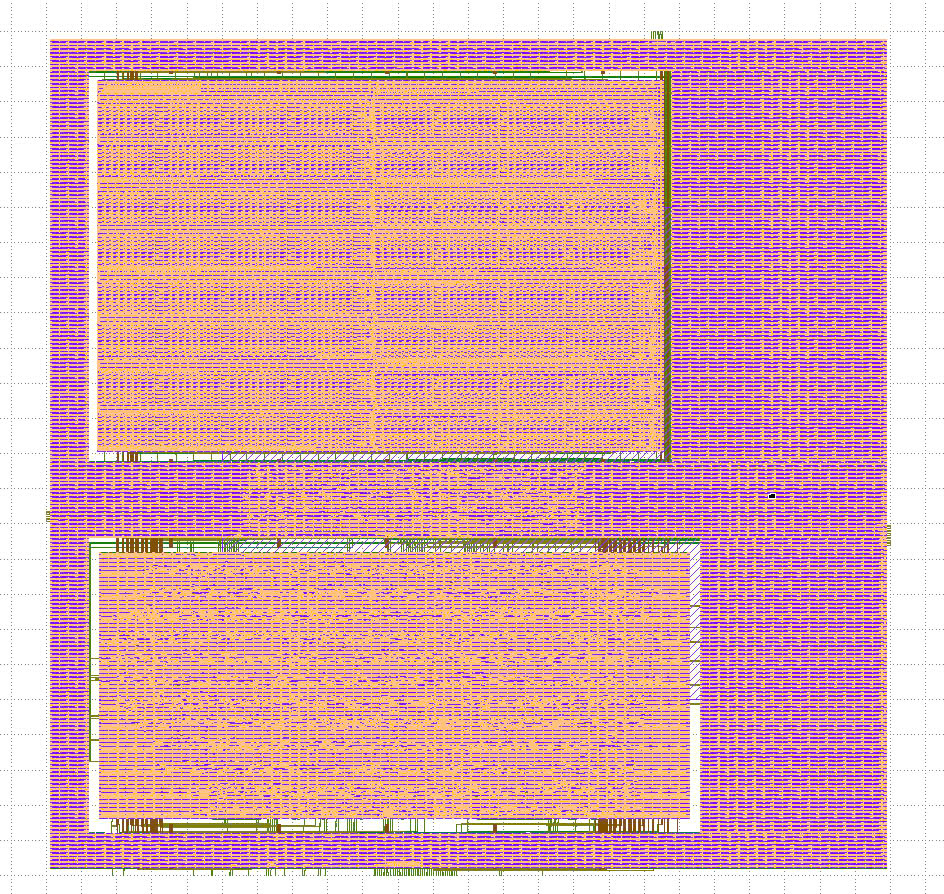